In [1]:
import pyomo.environ as pyo
from pyomo.network import Arc
from idaes.core import FlowsheetBlock, MaterialBalanceType
from idaes.models.unit_models import Valve
from idaes.models.unit_models.pressure_changer import Pump
from idaes.models.unit_models import Separator as Splitter
from idaes.models.unit_models.product import Product
from idaes.models.properties import iapws95
from idaes.core.util.initialization import propagate_state
from idaes.models.control.controller import (
    PIDController,
    ControllerType,
    ControllerMVBoundType
)
import idaes.core.util.scaling as iscale
from idaes.core.solvers import get_solver
from idaes.core.util.plot import plot_grid_dynamic

In [2]:
def _valve_pressure_flow_cb(b):
    """Callback for the pressure flow relations for the valves"""
    umeta = b.config.property_package.get_metadata().get_derived_units
    b.Cv = pyo.Var(
        initialize=0.1,
        doc="Valve flow coefficent",
        units=umeta("amount") / umeta("time") / umeta("pressure"),
    )
    b.Cv.fix()
    b.flow_var = pyo.Reference(b.control_volume.properties_in[:].flow_mol)
    b.pressure_flow_equation_scale = lambda x: x ** 2
    @b.Constraint(b.flowsheet().time)
    
    def pressure_flow_equation(PV_4, t):
        Po = PV_4.control_volume.properties_out[t].pressure
        Pi = PV_4.control_volume.properties_in[t].pressure
        F = PV_4.control_volume.properties_in[t].flow_mol
        valve_open = PV_4.valve_opening[t]
        Cv = (0.0615 * valve_open) - 0.0024
        return F ** 2 == Cv ** 2 * (Pi - Po) * valve_open ** 2    
    
#def perf_callback(blk):
#    @blk.Constraint(m.fs.config.time)
#    def Pdesc_calculation(P_4, t):
#        return P_4.outlet.pressure[t] == (
#            (-3874*m.fs.P_4.control_volume.properties_out[t].flow_mol**2)+
#            (-37153*m.fs.P_4.control_volume.properties_out[t].flow_mol)+
#            (2860479)
#        ) 
#    @blk.Constraint(m.fs.config.time)
#    def eff_calculation(P_4, t):
#        return P_4.efficiency_pump[t] == (
#            (-0.0068*m.fs.P_4.control_volume.properties_out[t].flow_mol**2)+
#            (0.1483*m.fs.P_4.control_volume.properties_out[t].flow_mol)+
#            (0.00252)
#        )
    
def _reduce_flow_step(m, time=1, value=11.5):
    """Add an inlet flow step change"""
    for t in m.fs.time:
        if t >= time:
            m.fs.P_4.inlet.flow_mol[t].fix(value)

def create_model(time_set=None, time_units=pyo.units.s, nfe=5, tee=False):

    m = pyo.ConcreteModel(name="Dynamic Pressure Control with PID Control")
    
    # Add flowsheet
    m.fs = FlowsheetBlock(dynamic=True, time_set=time_set, time_units=time_units)
    
    # Add water property parameter block
    m.fs.prop_water = iapws95.Iapws95ParameterBlock(
        phase_presentation=iapws95.PhaseType.L
    )
    
    # Add pump
    m.fs.P_4 = Pump (
        dynamic=False,
        property_package=m.fs.prop_water
#        isentropic_performance_curves={"build_callback": perf_callback}
    )
    
        # Add line to flow 
    m.fs.L_4 = Valve(
        dynamic=False,
        property_package = m.fs.prop_water
    )
    
    #Add splitter for recycle or pipe to injection
    m.fs.SP_1= Splitter(
        dynamic=False,
        property_package = m.fs.prop_water,
        outlet_list = ["PV_4","INJ_4"]
    )
    
    # Add control valve recycle
    m.fs.PV_4 = Valve(
        dynamic=False,
        has_holdup=False,
        pressure_flow_callback=_valve_pressure_flow_cb,
        material_balance_type=MaterialBalanceType.componentTotal,
        property_package=m.fs.prop_water,
    )
    
    m.fs.INJ_4 = Product (
        dynamic=False,
        property_package = m.fs.prop_water
    )
    
    # Add a controller
    m.fs.ctrl = PIDController(
        process_var=m.fs.L_4.control_volume.properties_out[:].pressure,
        manipulated_var=m.fs.PV_4.valve_opening,
        calculate_initial_integral=True,
        mv_bound_type=ControllerMVBoundType.SMOOTH_BOUND,
        controller_type=ControllerType.PI,
    )
        # The control volume block doesn't assume equilibrium, but the water is always liquid. there is no holdup.
        
        # Connect the models
    m.fs.P4_to_L4 = Arc(source=m.fs.P_4.outlet, destination=m.fs.L_4.inlet)
    m.fs.L4_to_SP1 = Arc(source=m.fs.L_4.outlet, destination=m.fs.SP_1.inlet)
    m.fs.SP1_to_PV4 = Arc(source=m.fs.SP_1.PV_4, destination=m.fs.PV_4.inlet)
    m.fs.SP1_to_INJ4 = Arc(source=m.fs.SP_1.INJ_4, destination=m.fs.INJ_4.inlet)
    
    # Add the stream constraints
    pyo.TransformationFactory("network.expand_arcs").apply_to(m.fs)

    # Do DAE discretization
    pyo.TransformationFactory("dae.finite_difference").apply_to(
        m.fs,
        nfe=nfe,
        wrt=m.fs.time,
        scheme="BACKWARD"
    )
    
      # Fix the derivative variables to zero at time 0 (steady state assumption)
    m.fs.fix_initial_conditions()

    # Fix the input variables
    Q_4 = 12
    Pdisc = (-3874*Q_4**2)+(-37153*Q_4)+(2850790)
    eff =  (-0.0068*Q_4**2)+(0.1483*Q_4)+(0.0252)
    Pin = 122003.6
    Tin = 333.15
    
    m.fs.P_4.inlet.flow_mol[0].fix(Q_4) # set properties of flow inlet in this case water inlet (0)
    m.fs.P_4.inlet.enth_mol[0].fix(4526.625) # J/mol # conditions of water inlyer
    m.fs.P_4.inlet.pressure[0].fix(122003.6) # Pa # set properties of pressure in this case water inlet (0)
    m.fs.P_4.outlet.pressure[0].fix(Pdisc) # set as constraint
    m.fs.P_4.efficiency_pump.fix(eff) # set efficiency as constraint 
    
    m.fs.L_4.Cv.fix(0.236998654)
    m.fs.L_4.valve_opening.fix(0.45)
    m.fs.L_4.inlet.flow_mol[0].unfix()
    
    m.fs.PV_4.Cv.fix(0.000365646)
    m.fs.PV_4.valve_opening.fix(0.1)
    m.fs.PV_4.inlet.flow_mol[0].unfix()
    
    m.fs.ctrl.gain_p.fix(1e-6) # porportional gain
    m.fs.ctrl.gain_i.fix(1e-5) # integral error gain
    m.fs.ctrl.setpoint.fix(1.9e6) # setpoint pressure of 1900 kPa
    m.fs.ctrl.mv_ref.fix(0) # controller bias
    m.fs.ctrl.mv_lb = 0.0 # valve opening lower bound is 0
    m.fs.ctrl.mv_ub = 1.0 # value opening upper bound is 1
    
    m.fs.SP_1.split_fraction[0, "PV_4"].fix(0.007)
    
    # Fix the derivative variables to zero at time 0 (steady state assumption)
    m.fs.fix_initial_conditions()
    
        # Initialize the model
    solver = get_solver(options={"max_iter": 100})

    for t in m.fs.time:
        m.fs.L_4.outlet.pressure[t] = 1839554 # initial pressure guess
        
    # simple initialize
    m.fs.P_4.initialize()
    propagate_state(m.fs.P4_to_L4)
    
    m.fs.L_4.initialize()
    propagate_state(m.fs.L4_to_SP1)
    
    m.fs.SP_1.initialize()
    propagate_state(m.fs.SP1_to_PV4)
    
    m.fs.PV_4.initialize()
    propagate_state(m.fs.SP1_to_INJ4)
    
    # Can't specify both flow and outlet pressure so free the outlet pressure
    # for initialization and refix it after.  Inlet flow gets fixed in init
    op = {}
    for t in m.fs.time:
        op[t] = pyo.value(m.fs.INJ_4.inlet.pressure[t])
        m.fs.INJ_4.inlet.pressure[t].unfix()
    m.fs.INJ_4.initialize()
    for t in m.fs.time:
        m.fs.INJ_4.inlet.pressure[t].fix(op[t])

    # Solve dynamic problem with deactivated controller
    m.fs.ctrl.deactivate()
    m.fs.PV_4.valve_opening.fix()
    solver.solve(m, tee=tee)

    # Solve dynamic problem with controller on
    m.fs.ctrl.activate()
    m.fs.PV_4.valve_opening.unfix()
    m.fs.PV_4.valve_opening[m.fs.time.first()].fix()
    solver.solve(m, tee=tee)

    # Return the model and solver
    return m, solver

In [3]:
# Create a model for the 0 to 12 sec time period
m, solver = create_model(time_set=[0, 10], nfe=10, tee=False)

# Add a step change in inlet flow in the pump
_reduce_flow_step(m, time=2, value= 11)

_reduce_flow_step(m, time=6, value= 10.6)

_reduce_flow_step(m, time=8, value= 10)
                 
# Solve with step change
solver.solve(m, tee=False)

2023-04-19 22:04:07 [INFO] idaes.init.fs.P_4.control_volume: Initialization Complete
2023-04-19 22:04:07 [INFO] idaes.init.fs.P_4: Initialization Complete: optimal - Optimal Solution Found
2023-04-19 22:04:07 [INFO] idaes.init.fs.L_4: Initialization Complete: optimal - Optimal Solution Found
2023-04-19 22:04:08 [INFO] idaes.init.fs.SP_1: Initialization Step 2 Complete: optimal - Optimal Solution Found
2023-04-19 22:04:08 [INFO] idaes.init.fs.PV_4: Initialization Complete: optimal - Optimal Solution Found
2023-04-19 22:04:08 [INFO] idaes.init.fs.INJ_4: Initialization Complete.
    model.name="Dynamic Pressure Control with PID Control";
      - termination condition: infeasible
      - message from solver: Ipopt 3.13.2\x3a Converged to a locally
        infeasible point. Problem may be infeasible.


{'Problem': [{'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 438, 'Number of variables': 468, 'Sense': 'unknown'}], 'Solver': [{'Status': 'warning', 'Message': 'Ipopt 3.13.2\\x3a Converged to a locally infeasible point. Problem may be infeasible.', 'Termination condition': 'infeasible', 'Id': 200, 'Error rc': 0, 'Time': 20.912194967269897}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

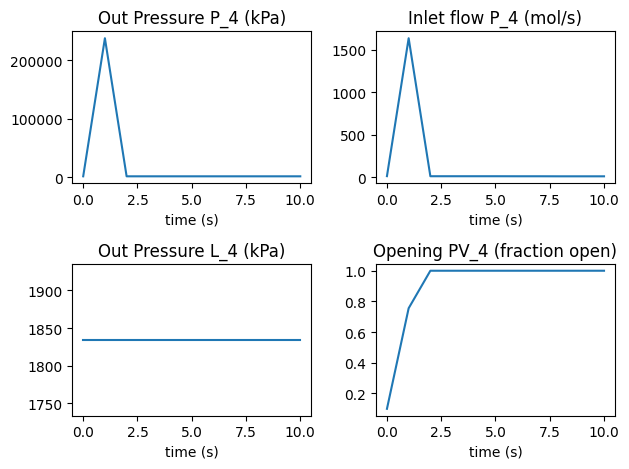

<module 'matplotlib.pyplot' from 'C:\\Users\\juanb\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [4]:
plot_grid_dynamic(
    x=m.fs.time,
    xlabel="time (s)",
    y=[
        m.fs.P_4.outlet.pressure,
        m.fs.P_4.inlet.flow_mol,
#        m.fs.P_4.control_volume.properties_in[:].flow_mol,
        m.fs.L_4.control_volume.properties_out[:].pressure,
        m.fs.PV_4.valve_opening,
    ],
    
    ylabel=[
        "Out Pressure P_4 (kPa)",
        "Inlet flow P_4 (mol/s)",
        "Out Pressure L_4 (kPa)",
        "Opening PV_4 (fraction open)",
    ],
    yunits=[
        pyo.units.kPa,
        pyo.units.mol*pyo.units.seconds**-1,
        pyo.units.kPa,
        None,
    ],
    cols=2,
    rows=2,
#    to_file="pid_pressure_pump.pdf"
)